In [1]:
import pandas as pd
import tensorflow 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

2024-05-09 03:50:04.594605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 03:50:04.594779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 03:50:04.726671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "latin-1"
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=columns).sample(frac=1)

dataset = dataset[['sentiment','text']]

dataset['sentiment'] = dataset['sentiment'].replace(4,1)



In [3]:
dataset[dataset['sentiment']==0]

,sentiment,text
317942,0,"everyone likes the MX2, cept me I am a loner..."
183827,0,The new prada record is VERY disappointing. De...
55851,0,Does not want to be here
528165,0,@summerblonde83 SWEET!! send me the link to th...
16845,0,"I'm hungry, but of course there's nothing to e..."
...,...,...
390191,0,I want to go back to bed. Yup. That sounds lik...
716615,0,"@vara411 their prices are good, its just veriz..."
368260,0,"well if bella is going, then so am i"
372053,0,i'm the slowest lighter ever. no way this anim...


In [4]:
dataset['sentiment'].unique()

array([0, 1])

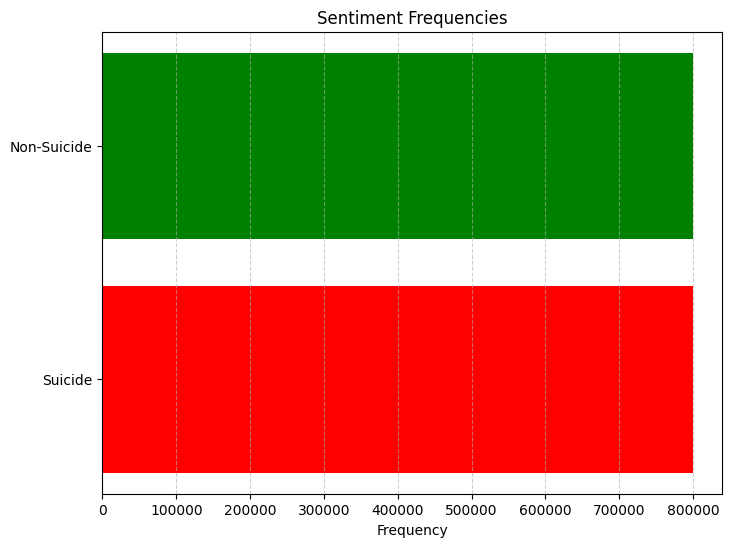

In [5]:
plt.rcParams['font.family'] = 'DejaVu Sans'
sentiment_counts = dataset['sentiment'].value_counts()
sentiment_labels = {'Suicide': 0, 'Non-Suicide': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['red', 'green', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment Frequencies")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [6]:
dataset.isna().sum()

sentiment    0
text         0
dtype: int64

In [7]:
x,y=dataset['text'],dataset['sentiment']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)

In [10]:
len(x_train),len(x_test)

(1280000, 320000)

In [11]:
def process_text(document,stopwords=STOPWORDS):
    nlp = spacy.load("en_core_web_sm")
    document = re.sub(r'\s+', ' ', document, flags=re.I) 
    document = re.sub(r'\W', ' ', str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) 
    document = document.lower() 
    doc_spacy=nlp(document)
    lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
    lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
    lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]
    clean_txt = ' '.join(lemma_no_stop_txt)
    return clean_txt

x_train_preprocessed= x_train

In [13]:
x_train_preprocessed


983784     @rooreynolds Interesting. I enjoyed some of th...
750232     Things always go crumbling down. I miss@meghan...
959217     Making some breakfast  Way to get me in troubl...
142610     wow that was possibly the worst exam in my lif...
766832     it's hotter than hell and i have to work until...
                                 ...                        
291647     Of course need-based aid is on the chopping bl...
783522     Drinking tea as opposed to seeing Dash &amp; W...
500834                    @Sheenee no  hasn't tweeted either
1040544    @bluestreak23 Haha yep its definitely not goin...
178870     @giselle2323 - Hopefully he won't discover all...
Name: text, Length: 1280000, dtype: object

In [14]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train_preprocessed)  # Ensure consistent preprocessing
X_train_sequences = tokenizer.texts_to_sequences(x_train_preprocessed)
X_test_sequences = tokenizer.texts_to_sequences(x_test)
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
pd.DataFrame({'words':tokenizer.sequences_to_texts(list(X_train_sequences)),'sequances':X_train_sequences})

,words,sequances
0,rooreynolds interesting i enjoyed some of thos...,"[59635, 711, 2, 1047, 71, 13, 293, 103, 11880,..."
1,things always go crumbling down i miss meghanw...,"[247, 199, 38, 26554, 164, 2, 89, 196356, 7, 9..."
2,making some breakfast way to get me in trouble...,"[346, 71, 545, 131, 3, 34, 15, 12, 1196, 14309..."
3,wow that was possibly the worst exam in my life,"[256, 18, 26, 1724, 4, 735, 463, 12, 6, 191]"
4,it's hotter than hell and i have to work until...,"[43, 4874, 207, 479, 7, 2, 17, 3, 46, 310, 2547]"
...,...,...
1279995,of course need based aid is on the chopping bl...,"[13, 535, 94, 2420, 4445, 9, 14, 4, 18210, 165..."
1279996,drinking tea as opposed to seeing dash amp wil...,"[790, 683, 85, 13579, 3, 540, 7125, 66, 58, 22..."
1279997,sheenee no hasn't tweeted either,"[595385, 37, 1276, 1630, 488]"
1279998,bluestreak23 haha yep its definitely not going...,"[79206, 107, 752, 72, 628, 25, 48, 3, 23, 197,..."


In [15]:
y_train

983784     1
750232     0
959217     1
142610     0
766832     0
          ..
291647     0
783522     0
500834     0
1040544    1
178870     0
Name: sentiment, Length: 1280000, dtype: int64

In [16]:
len(tokenizer.word_index)

595385

In [17]:
model = Sequential([
Embedding(len(tokenizer.word_index)+1, 64),
Conv1D(64, 3, activation='relu'),
MaxPooling1D(2,2),
Dropout(0.2),
Conv1D(32,3, activation='relu'),
MaxPooling1D(2,2),
Flatten(),
Dense(8, activation='relu'),
Dense(1, activation='sigmoid'),]
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
Early_Stopping=tensorflow.keras.callbacks.EarlyStopping(patience=3,verbose=1)
history=model.fit(X_train_padded,y_train, epochs=15,batch_size=128,callbacks=[Early_Stopping])

Epoch 1/15
   19/10000 ━━━━━━━━━━━━━━━━━━━━ 1:26 9ms/step - accuracy: 0.5130 - loss: 0.6931

I0000 00:00:1715226936.333966     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.7828 - loss: 0.4550
Epoch 2/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8695 - loss: 0.3078
Epoch 3/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9092 - loss: 0.2236
Epoch 4/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9294 - loss: 0.1766
Epoch 5/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9425 - loss: 0.1454
Epoch 6/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9512 - loss: 0.1240
Epoch 7/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9571 - loss: 0.1096
Epoch 8/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9609 - loss: 0.1000
Epoch 9/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9644 - loss: 0.0910
Epoch 10/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9671 - loss: 0.0845
Epoch 11/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9692 - loss: 0.0794
Epoch 12

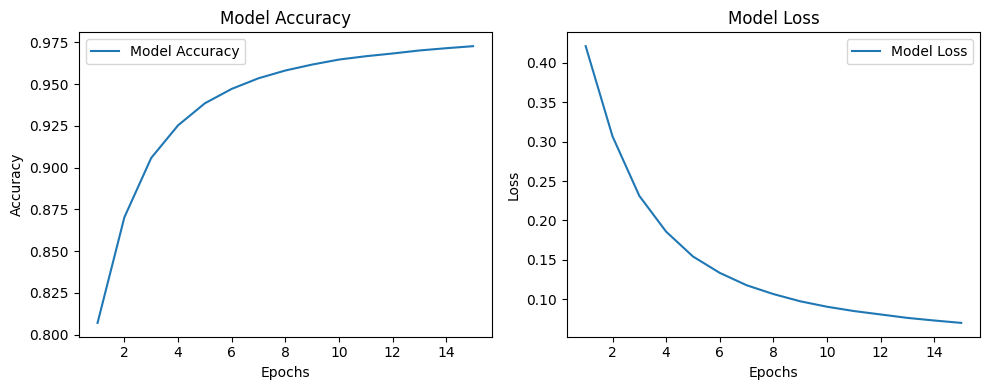

In [19]:
import matplotlib.pyplot as plt

def plot_model_history(history):

    model_accuracy = history.history['accuracy']
    model_loss = history.history['loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(model_accuracy) + 1), model_accuracy, label='Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(model_loss) + 1), model_loss, label='Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(history)





In [20]:
model.evaluate(X_test_padded,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7852 - loss: 0.8195


[0.8171993494033813, 0.7854375243186951]

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 118, 64)         │    38,104,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (128, 116, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (128, 58, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 58, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (128, 56, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (128, 28, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (128, 896)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 8)               │         7,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 1)               │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,391,253 (436.37 MB)

 Trainable params: 38,130,417 (145.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,260,836 (290.91 MB)

In [23]:
X_train_padded

array([[    0,     0,     0, ...,   293, 14074,  5136],
       [    0,     0,     0, ...,     7,    94,   108],
       [    0,     0,     0, ..., 10336,   163,   105],
       ...,
       [    0,     0,     0, ...,  1276,  1630,   488],
       [    0,     0,     0, ...,   145,    11,   203],
       [    0,     0,     0, ...,  4770,  3150,   430]], dtype=int32)

In [24]:
def predict_sentiment(input_text, model, tokenizer,max_sequence_length=max_sequence_length):
    classes = ['Suicide', 'Non-Suicide']
    x_test_sequences = tokenizer.texts_to_sequences(input_text)
    X_test_padded = pad_sequences(x_test_sequences, maxlen=max_sequence_length, truncating='pre')
    probabilities = model.predict(X_test_padded)
    predictions = classes[int(np.round([i for i in probabilities]))]
    return predictions



In [25]:
 predict_sentiment(['ifeel that i didnt drink any coffe from 10 months'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


'Suicide'

In [26]:
 predict_sentiment(['ifeel that drink  coffe ,iam happy and have big contractions '], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Non-Suicide'

In [27]:
 predict_sentiment(['You’re doing great!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Non-Suicide'

In [28]:
 predict_sentiment(['negative!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Suicide'

In [29]:
 predict_sentiment(['You’re doing bad!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Suicide'

In [30]:
 predict_sentiment(['I want to die'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Suicide'

In [31]:
 predict_sentiment(['I will kill my self!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Suicide'

In [32]:
 predict_sentiment(['I will burn my self!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Non-Suicide'

In [33]:
 predict_sentiment(['I am happy its my birthday!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Non-Suicide'

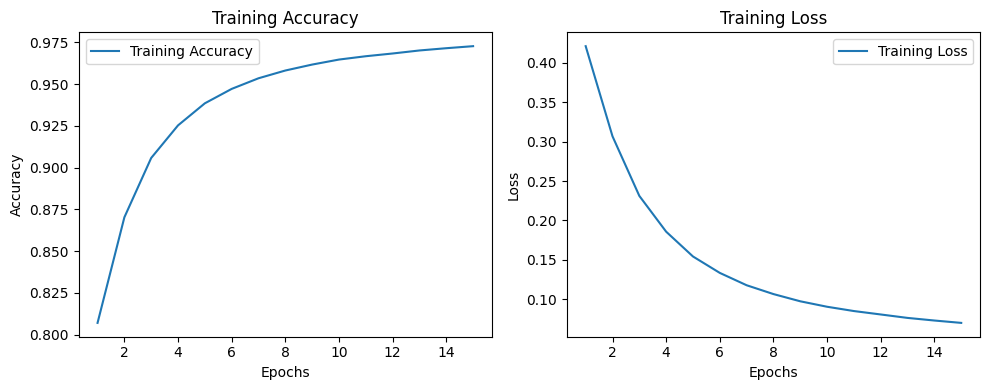

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [39]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
